<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios_Mes_Seguinte_Escondido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uma variação do notebook original, sem split e uso do mês seguinte como validador

# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import datetime
import pickle

In [2]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/Amostra Completa - Mercado Futuro.csv", sep=";", decimal=",")

In [3]:
#converte o campo data (string) em formato de data
historic['DataFormatada'] = pd.to_datetime(historic['Data'], format='%d/%m/%Y')
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Saldo Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,...,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77,DataFormatada
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,...,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,...,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,...,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4,2019-01-02
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,...,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4,2019-01-02
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,...,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4,2019-01-02


In [4]:
#separa um mês em cada  dataframe e faz todas as operações de preparação do daframe criado
variables = locals()
for i in range(1,13):
  mes = str(i).zfill(2)
  variables["mes{0}".format(mes)] = historic[historic['DataFormatada'].dt.month == i]
  #separa o target e o código da operação
  variables["target{0}".format(mes)] = variables["mes{0}".format(mes)][['CodOp', 'Resultado']].copy()
  #indica o campo CodOp como índice nos 2 dataframes (para conferência futura)
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].set_index('CodOp')
  variables["target{0}".format(mes)] = variables["target{0}".format(mes)].set_index('CodOp')
  #apaga o campo target do dataframe original e outros campos já definidos como não necessários
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].drop(['Resultado', 'Hora Entrada', 'Hora Saida',
                                                                          'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos',
                                                                          'Perdas', 'Saldo Trade', 'K entra', 'K Saida', 'DataFormatada'], axis=1)

# Criando um arquivo separado com base no mês para teste

In [5]:
mesesTreino = ['01', '02', '03'] #train
mesValidacao = '04' #test

In [19]:
#prepara os datasets de acordo com os meses informados
variables = locals()
X_train = variables["mes{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  X_train = X_train.append(variables["mes{}".format(mesesTreino[i])])
print(X_train.shape)

X_test = variables["mes{}".format(mesValidacao)].copy()
print(X_test.shape)

#e também dos objetivos para validação
y_train = variables["target{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  y_train = y_train.append(variables["target{}".format(mesesTreino[i])])
print(y_train.shape)

y_test = variables["target{}".format(mesValidacao)].copy()
print(y_test.shape)
#converte em array
y_test = y_test.values.ravel()

(9360, 77)
(3336, 77)
(9360, 1)
(3336, 1)


# Seleção de variáveis baseada no classificador

In [24]:
#cria função para avaliar importância
def etc_importances(features_interna, outcome_interna, n_estimators):
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  model.fit(features_interna, np.array(outcome_interna).ravel())

  importances = model.feature_importances_
  variables = np.array(features_interna.columns)
  indices = np.argsort(importances)[::-1] #tudo, em ordem decrescente
  importances = importances[indices]
  variables = variables[indices]

  return variables, importances

In [28]:
#cria função para plotar importâncias x variáveis acumulado
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum() #soma todas as colunas anteriores a i
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index=True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

In [37]:
variables, importances = etc_importances(X_train, y_train, n_estimators=300)

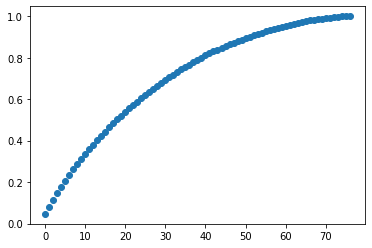

In [38]:
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)

In [39]:
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
sum_importances

,0,1
0,Item 2,0.046472
1,Item 3,0.081895
2,Item 8,0.114585
3,Item 17,0.146250
4,Item 1,0.176481
...,...,...
72,Item 49,0.995798
73,Item 21,0.997801
74,Item 51,0.998922
75,Item 50,1.000000


In [40]:
#lista a quantidade de ocorrência por resultado para avaliar em y_train e y_test
print("Total de resultado 1 e 2 em treino: ", sum(num == 1 for num in y_train.values.ravel()), '+', sum(num == 2 for num in y_train.values.ravel()), '=', len(y_train.values.ravel()))
print("Total de resultado 1 e 2 em teste: ", sum(num == 1 for num in y_test), '+', sum(num == 2 for num in y_test), '=', len(y_test))

Total de resultado 1 e 2 em treino:  4492 + 4868 = 9360
Total de resultado 1 e 2 em teste:  1479 + 1857 = 3336


# Modelagem

In [41]:
#faz a função para mostrar AUC e ROC
def rfc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return rfc

In [42]:
#gera o modelo
model = rfc_test(X_train, y_train, cv=20, n_estimators=340)

Média dos 20 testes:  0.45276743351809284


In [43]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=340,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2

In [45]:
valoresPrevistos

array([2, 2, 2, ..., 2, 2, 2])

In [46]:
y_test

array([1, 2, 2, ..., 2, 2, 2])

In [47]:
#lista comparação dos primeiros 50 registros
print("Previsto x Real")
for i in range(0, 30):
  if valoresPrevistos[i] != y_test[i]:
    print("   {} x   {}".format(valoresPrevistos[i], y_test[i]), end=' ')
    print(" <<<--- falha")
  else:
    print("   {} x   {}".format(valoresPrevistos[i], y_test[i]))


Previsto x Real
   2 x   1  <<<--- falha
   2 x   2
   2 x   2
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   1 x   1
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   1  <<<--- falha
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   1  <<<--- falha
   2 x   2
   2 x   2
   2 x   2
   2 x   2
   2 x   1  <<<--- falha


In [48]:
#lista quantidade de acertos
contaOk = 0
contaNao = 0
for i in range(0, len(y_test)):
  if valoresPrevistos[i] == y_test[i]:
    contaOk += 1
  else:
    contaNao += 1

print("Quantidade de resultados OK: {}\nQuantidade de resultados Não: {}".format(contaOk, contaNao))
print("Percentual de acertos: {:.1f}%".format(contaOk/len(y_test)*100))

Quantidade de resultados OK: 1947
Quantidade de resultados Não: 1389
Percentual de acertos: 58.4%
